**Проект: вариант 3**

Представьте, что вы работаете в крупном дейтинговом приложении.

Помимо базовых функций, в приложении также имеется премиум-подписка, которая дает доступ к ряду важных дополнительных возможностей. Был проведен A/B тест, в рамках которого для новых пользователей из нескольких стран была изменена стоимость премиум-подписки* при покупке через две новые платежные системы. При этом стоимость пробного периода оставалась прежней.

Проверьте:

Был ли эксперимент успешен в целом.
*Деньги за подписку списываются ежемесячно до тех пор, пока пользователь её не отменит.

**Данные**

Всего есть три группы: тестовая (test), контрольная 1 (control_1) и контрольная 2 (control_2). 

Для каждой из них:

_users_*.csv – информация о пользователях:_

uid – идентификатор пользователя

age – возраст

attraction_coeff – коэффициент привлекательности

coins – число монеток (внутренняя валюта)

country – страна  

visit_days – в какие дни после регистрации пользователь посещал приложение (напр. в 1, затем в 7)

gender – пол

age_filter_start  – фильтр поиска, мин. значение 

age_filter_end  – фильтр поиска, макс. значение 

views_count – число полученных оценок 

was_premium – был ли когда-либо премиум (либо пробный период премиум-статуса, либо купленный за деньги)

is_premium –  является ли премиум

total_revenue – нормированная выручка 

_transactions_*.csv – информация о платежах пользователей:_

uid – идентификатор пользователя

country – страна

joined_at – дата и время регистрации

paid_at – дата и время покупки

revenue – нормированная выручка

payment_id – идентификатор платежа

from_page – откуда пользователь перешел на страницу оплаты

product_type – тип продукта (trial_premium – пробная премиум-подписка, premium_no_trial – премиум-подписка без пробной, coins – подписка за внутреннюю валюту, other_type – другое) 

**Файлы:**

users_test – информация о пользователях в тестовой группе.

users_control_1 – информация о пользователях в первой контрольной группе. 

users_control_2 – информация о пользователях во второй контрольной группе . 

transactions_test – информация о платежах пользователей в тестовой группе. 

transactions_control_1 – информация о платежах пользователей в первой контрольной группе. 

transactions_control_2 – информация о платежах пользователей во второй контрольной группе 

In [134]:
import pandas as pd
import numpy as np
import scipy.stats as ss
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.api import anova_lm
from statsmodels.stats.multicomp import (pairwise_tukeyhsd,
                                         MultiComparison)
import scipy
from scipy.stats import bootstrap
from scipy.stats import shapiro
import plotly.express as px


%matplotlib inline
import pingouin as pg

import matplotlib.pyplot as plt
import seaborn as sns



%matplotlib inline

Считываем данные

In [135]:
import requests
from urllib.parse import urlencode


base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
data_1 = 'https://disk.yandex.ru/d/4XXIME4osGrMRA'
data_2 = 'https://disk.yandex.ru/d/yJFydMNNGkEKfg'
data_3 = 'https://disk.yandex.ru/d/br6KkQupzzTGoQ'
data_4 = 'https://disk.yandex.ru/d/gvCWpZ55ODzs2g'
data_5 = 'https://disk.yandex.ru/d/VY5W0keMX5TZBQ'
data_6 = 'https://disk.yandex.ru/d/th5GL0mGOc-qzg'

In [136]:
# Получаем загрузочную ссылку для data_1 (содержит информацию о пользователях в тестовой группе)
df_final_url = base_url + urlencode(dict(public_key=data_1))
response = requests.get(df_final_url)
df_download_url_1 = response.json()['href']

# Получаем загрузочную ссылку для data_2 (содержит информацию о пользователях в первой контрольной группе)
df_final_url_2 = base_url + urlencode(dict(public_key=data_2))
response = requests.get(df_final_url_2)
df_download_url_2 = response.json()['href']

# Получаем загрузочную ссылку для data_3 (содержит информацию о пользователях во второй контрольной группе)
df_final_url_3 = base_url + urlencode(dict(public_key=data_3))
response = requests.get(df_final_url_3)
df_download_url_3 = response.json()['href']

# Получаем загрузочную ссылку для data_4 (содержит информацию о платежах пользователей в тестовой группе)
df_final_url_4 = base_url + urlencode(dict(public_key=data_4))
response = requests.get(df_final_url_4)
df_download_url_4 = response.json()['href']

# Получаем загрузочную ссылку для data_5 (содержит информацию о платежах пользователей в первой контрольной группе)
df_final_url_5 = base_url + urlencode(dict(public_key=data_5))
response = requests.get(df_final_url_5)
df_download_url_5 = response.json()['href']

# Получаем загрузочную ссылку для data_6 (содержит информацию о платежах пользователей во второй контрольной группе)
df_final_url_6 = base_url + urlencode(dict(public_key=data_6))
response = requests.get(df_final_url_6)
df_download_url_6 = response.json()['href']

**Тестовая группа**

Считываем датафрейм, который содержит информацию о пользователях в тестовой группе

In [137]:
users_test = pd.read_csv(df_download_url_1, sep=';')
users_test.shape

(4308, 13)

Добавим столбец "grp" с признаком группы test = 1, control_1 = 2, control_2 = 3

In [138]:
users_test['grp'] = 1

Посмотрим сразу на уникальность пользователей (есть ли у нас повторения)

Повторений нет 4308 пользователей всего в тестовой группе

In [139]:
users_test.uid.nunique()

4308

Считываем датафрейм, который содержит информацию о платежах пользователей в тестовой группе. Добавим признак 'payment' = 1, в дальнейшем буде использовать.

In [140]:
transactions_test = pd.read_csv(df_download_url_4, sep=';')
transactions_test['payment'] = 1

Посмотрим так же на уникальность пользователей

Уникальность показала, что есть пользователи, которые повторяются

In [141]:
transactions_test.uid.nunique()

146

Объеденяем датафреймы users_test и transactions_test, получаем датафрейм group_test с полной информацией о пользователях в тестовой группе

In [142]:
group_test = users_test.merge(transactions_test, how = 'left', on='uid')
group_test.shape

(4435, 22)

Проверим на уникальность

In [143]:
group_test.uid.nunique()

4308

Найдем дубликаты

In [144]:
group_test.loc[group_test.duplicated()]

,uid,age,attraction_coeff,coins,country_x,visit_days,gender,age_filter_start,age_filter_end,views_count,...,total_revenue,grp,country_y,joined_at,paid_at,revenue,payment_id,from_page,product_type,payment
425,892236423,23,262,378.0,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...",1,19,23,1326,...,95823,1,United States of America,2017-10-18 01:09:00,2017-10-23 00:15:00,3783.0,67.0,menu,other_type,1.0
430,892236423,23,262,378.0,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...",1,19,23,1326,...,95823,1,United States of America,2017-10-18 01:09:00,2017-10-27 22:38:00,3783.0,67.0,menu,other_type,1.0
433,892236423,23,262,378.0,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...",1,19,23,1326,...,95823,1,United States of America,2017-10-18 01:09:00,2017-10-22 22:08:00,1261.0,19.0,empty_likes,coins,1.0
803,891508155,34,101,1.0,Latvia,"1,2,3,4,5,6,7,8,9,10,11,12,13",1,20,32,226,...,10101,1,Latvia,2017-02-11 09:46:00,2017-03-11 22:06:00,936.0,19.0,empty_likes,coins,1.0
1799,892050108,51,239,6.0,Israel,"1,2,3,4,5,6,7,9",1,37,42,364,...,16380,1,Israel,2017-10-22 03:02:00,2017-10-23 02:53:00,1261.0,19.0,empty_likes,coins,1.0
1972,892339626,37,684,NaN,United States of America,"1,2,3,4,5,9,10,11,12,14,15,16,17,18,19,20,21,2...",1,18,40,263,...,17758,1,United States of America,2017-10-15 23:21:00,2017-10-20 18:14:00,754.0,19.0,empty_likes,coins,1.0
2721,892202526,21,491,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,13,15,16,17,18,19,2...",1,18,35,59,...,2691,1,United States of America,2017-10-18 20:34:00,2017-10-20 19:54:00,897.0,19.0,menu,coins,1.0


Почистим наши данные, удалим дубликаты

In [145]:
group_test = group_test.drop_duplicates()

In [146]:
group_test.shape

(4428, 22)

Так же убедимся, что нет пропущенных значений в столбце uid с индетификаторами пользователей

In [147]:
group_test.isna().sum()

uid                    0
age                    0
attraction_coeff       0
coins               4281
country_x              0
visit_days          1331
gender                 0
age_filter_start       0
age_filter_end         0
views_count            0
was_premium         3902
is_premium          4160
total_revenue          0
grp                    0
country_y           4162
joined_at           4162
paid_at             4162
revenue             4162
payment_id          4162
from_page           4162
product_type        4162
payment             4162
dtype: int64

**Первая контрольная группа**

Считываем датафрейм, который содержит информацию о пользователях в первой контрольной группе

In [148]:
users_control_1 = pd.read_csv(df_download_url_2, sep=';')
users_control_1.shape

(4340, 13)

Добавим столбец "grp" с признаком группы test = 1, control_1 = 2, control_2 = 3

In [149]:
users_control_1['grp'] = 2

Посмотрим сразу на уникальность пользователей (есть ли у нас повторения). Повторений нет, всего 4340 пользователей.

In [150]:
users_control_1.uid.nunique()

4340

Считываем датафрейм, который содержит информацию о платежах пользователей в первой контрольной группе. Добавим признак 'payment' = 1, в дальнейшем буде использовать.

In [151]:
transactions_control_1 = pd.read_csv(df_download_url_5, sep=';')
transactions_control_1['payment'] = 1
transactions_control_1.shape

(1007, 9)

In [152]:
transactions_control_1.uid.nunique()

193

Объеденяем датафреймы users_control_1 и transactions_control_1, получаем датафрейм group_control_1 с полной информацией о пользователях в первой контрольной группе

In [153]:
group_control_1 = users_control_1.merge(transactions_control_1, how = 'left', on='uid')
group_control_1.shape

(4524, 22)

In [154]:
group_control_1.uid.nunique()

4340

Поищем дубликаты. Обнаруженные дубликаты удаляем.

In [155]:
group_control_1.loc[group_control_1.duplicated()]

,uid,age,attraction_coeff,coins,country_x,visit_days,gender,age_filter_start,age_filter_end,views_count,...,total_revenue,grp,country_y,joined_at,paid_at,revenue,payment_id,from_page,product_type,payment
265,891367521,25,129,1.0,Italy,"1,2,3,5,6,7,8",1,16,99,62,...,20462,2,Italy,2017-05-11 02:37:00,2017-10-11 01:52:00,1469.0,19.0,sympathy,other_type,1.0
268,891367521,25,129,1.0,Italy,"1,2,3,5,6,7,8",1,16,99,62,...,20462,2,Italy,2017-05-11 02:37:00,2017-06-11 17:43:00,1456.0,127.0,sympathy,other_type,1.0
269,891367521,25,129,1.0,Italy,"1,2,3,5,6,7,8",1,16,99,62,...,20462,2,Italy,2017-05-11 02:37:00,2017-06-11 17:43:00,1456.0,127.0,sympathy,other_type,1.0
1362,891721851,27,411,10.0,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18",1,23,29,90,...,18174,2,United States of America,2017-10-29 02:50:00,2017-11-14 04:08:00,897.0,19.0,empty_likes,coins,1.0
1471,892333905,22,175,3608.0,Italy,"1,2,3,4,5,6,7,15",1,19,25,575,...,486330,2,Italy,2017-10-16 01:38:00,2017-10-16 01:44:00,3783.0,67.0,menu,other_type,1.0
1475,892333905,22,175,3608.0,Italy,"1,2,3,4,5,6,7,15",1,19,25,575,...,486330,2,Italy,2017-10-16 01:38:00,2017-10-16 01:58:00,3783.0,67.0,empty_admins,other_type,1.0
1481,892333905,22,175,3608.0,Italy,"1,2,3,4,5,6,7,15",1,19,25,575,...,486330,2,Italy,2017-10-16 01:38:00,2017-10-16 01:44:00,3783.0,67.0,menu,other_type,1.0
1482,892333905,22,175,3608.0,Italy,"1,2,3,4,5,6,7,15",1,19,25,575,...,486330,2,Italy,2017-10-16 01:38:00,2017-10-16 01:58:00,3783.0,67.0,empty_admins,other_type,1.0
1484,892333905,22,175,3608.0,Italy,"1,2,3,4,5,6,7,15",1,19,25,575,...,486330,2,Italy,2017-10-16 01:38:00,2017-10-16 02:08:00,1261.0,19.0,gifts,coins,1.0
1486,892333905,22,175,3608.0,Italy,"1,2,3,4,5,6,7,15",1,19,25,575,...,486330,2,Italy,2017-10-16 01:38:00,2017-10-16 01:57:00,3783.0,67.0,empty_admins,other_type,1.0


In [156]:
group_control_1 = group_control_1.drop_duplicates()

In [157]:
group_control_1.shape

(4503, 22)

Проверим на наличие пропущенных значений

In [158]:
group_control_1.isna().sum()

uid                    0
age                    0
attraction_coeff       0
coins               4305
country_x              0
visit_days          1324
gender                 0
age_filter_start       0
age_filter_end         0
views_count            0
was_premium         3917
is_premium          4180
total_revenue          0
grp                    0
country_y           4147
joined_at           4147
paid_at             4147
revenue             4147
payment_id          4147
from_page           4147
product_type        4147
payment             4147
dtype: int64

**Вторая контрольная группа**

Считываем датафрейм, который содержит информацию о пользователях во второй контрольной группе

In [159]:
users_control_2 = pd.read_csv(df_download_url_3, sep=';')
users_control_2.shape

(4264, 13)

Добавим столбец "grp" с признаком группы test = 1, control_1 = 2, control_2 = 3

In [160]:
users_control_2['grp'] = 3

Посмотрим сразу на уникальность пользователей (есть ли у нас повторения). Повторений нет, всего 4264 пользователей.

In [161]:
users_control_2.uid.nunique()

4264

Считываем датафрейм, который содержит информацию о платежах пользователей во второй контрольной группе. Добавим признак 'payment' = 1, в дальнейшем буде использовать.

In [162]:
transactions_control_2 = pd.read_csv(df_download_url_6, sep=';')
transactions_control_2['payment'] = 1
transactions_control_2.shape

(328, 9)

Объеденяем датафреймы users_control_2 и transactions_control_2, получаем датафрейм group_control_2 с полной информацией о пользователях во второй контрольной группе

In [163]:
group_control_2 = users_control_2.merge(transactions_control_2, how = 'left', on='uid')
group_control_2.shape

(4405, 22)

In [164]:
group_control_2.uid.nunique()

4264

Поищем дубликаты. Обнаруженные дубликаты удаляем.

In [165]:
group_control_2.loc[group_control_2.duplicated()]

,uid,age,attraction_coeff,coins,country_x,visit_days,gender,age_filter_start,age_filter_end,views_count,...,total_revenue,grp,country_y,joined_at,paid_at,revenue,payment_id,from_page,product_type,payment
292,892064328,55,372,68.0,United States of America,"1,2,3,4,5",1,52,58,212,...,18902,3,United States of America,2017-10-21 20:54:00,2017-10-22 01:30:00,6305.0,19.0,empty_likes,coins,1.0
680,892009254,21,0,NaN,Italy,"1,3,4,5,6,7",1,18,24,0,...,7072,3,Italy,2017-10-22 22:57:00,2017-10-23 00:06:00,2353.0,67.0,empty_likes,other_type,1.0
691,892062660,36,560,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...",1,28,55,175,...,2522,3,United States of America,2017-10-21 21:28:00,2017-10-31 00:53:00,1261.0,19.0,empty_likes,coins,1.0
1614,891862596,28,380,6.0,Italy,"1,2,3,4,5,6",1,25,31,21,...,10075,3,Italy,2017-10-26 01:40:00,2017-10-30 09:01:00,1261.0,19.0,empty_likes,coins,1.0
2319,892045743,26,220,6.0,Israel,"1,2,3,4,5,6,7,8,9,11,12,13,14,15,16,18,20,22,2...",1,23,29,59,...,10075,3,Israel,2017-10-22 07:04:00,2017-10-23 20:17:00,1261.0,19.0,empty_likes,coins,1.0


In [166]:
group_control_2 = group_control_2.drop_duplicates()

In [167]:
group_control_2.shape

(4400, 22)

**Сформируем одну таблицу group_all**, с которой мы будем работать, в ней будут собраны все три группы пользователей (group_test + group_control_1 + group_control_2)

Сразу удалила ненужный столбец "country_y", так как он дублируется с "country_x" и удалила столбцы, которые точно не будут задействованы

In [168]:
group_all = pd.concat([group_test, group_control_1, group_control_2]).reset_index().drop(columns='index')
group_all = group_all.drop(columns='country_y')
group_all = group_all.rename(columns = {'country_x': 'country'})
group_all = group_all.fillna(0)
group_all = group_all.astype({'country': 'str', 'visit_days': 'str', 'grp': 'str'})
group_all = group_all.drop(columns='views_count')

In [169]:
group_all.shape

(13331, 20)

In [170]:
group_all = group_all.drop_duplicates()

In [171]:
group_all.shape

(13331, 20)

Оставим только уникальные значения в получившемся датафрейме group_all

In [172]:
group_all.uid.nunique()

12912

In [173]:
group_all = group_all.drop_duplicates(subset=['uid'])

In [174]:
group_all.shape

(12912, 20)

Сделаем признак столбца "gender" более понятным и читаемым, это пригодится в дальнейшем

In [175]:
group_all.gender = group_all.gender.apply(lambda x: 'male' if x == 1 else 'female')

Рассмотрим столбец с датой регистрации (joined_at) и посмотрим, каких пользователей можно называть "новыми пользователями". Приведем столбец (joined_at) к формату, который нам нужен, а именно вынесем оттуда только дату регистрации в новый столбец (joined_date).

In [176]:
group_all['joined_date'] = pd.to_datetime(group_all['joined_at']).dt.date

In [177]:
group_all_joined = group_all.groupby('joined_date', as_index=False).agg({'uid':'count'}).rename(columns = {'uid': 'count_uid'})
group_all_joined.head()

,joined_date,count_uid
0,1970-01-01,12386
1,2015-01-19,1
2,2017-01-11,14
3,2017-02-11,16
4,2017-03-11,13


Можем наблюдать, что у 12386 пользователей нет даты регистрации, а это 96% от общего кол-ва пользователей.

Построим график, на котором будет видно кол-во пользователей по дням регистрации, но предварительно уберем пользователей, у которых нет даты регистрации, чтобы избежать искажения информации.

In [178]:
group_all_joined_1 = group_all_joined.query('count_uid < 10000').sort_values('joined_date')
group_all_joined_1.sum()

count_uid    526
dtype: int64

In [179]:
px.line(group_all_joined_1, x="joined_date", y="count_uid")

На графике можем наблюдать, что регистрация пользователей началась с января 2017, думаю, что первые три пользователя в январе 2015 были работники, которые создавали это приложение, так как между большой период. Хотя если учесть, что у большого кол-ва пользователей, вообще отсутсвует дата регистрации, я могу ошибаться. Так же можем наблюдать резкий вплеск регистрации 21 октября 2017, возможно был запуск какой-то рекламы, которая привлекла пользователей.

Хочу посмотреть, есть ли какая-то зависимость между paid_at и joined_at, думаю, что дата регистрации появляется только после того, как пользователь покупает подписку, что для меня странно. 

In [180]:
group_all_paid = group_all.query("paid_at != 0")

In [181]:
group_all_paid_1 = group_all_paid.groupby('joined_date', as_index=False).agg({'uid':'count'}).rename(columns = {'uid': 'count_uid'})
group_all_paid_1.sum()

count_uid    526
dtype: int64

Судя по одинаковому кол-ву пользователей (526), мои предположения верны, что дата регистрации появляется только после того, как пользователь покупает подписку.

Не согласна с такими данными, так как думаю, что дату регистрации надо передавать сразу в датафрейм, после того, как пользователь регистрируется в приложении. Для того, чтобы мы могли отследить больше информации о пользователях. А так получается, что мы берем во внимание только тех пользователей, которые покупают у нас подписку. Например, мы не можем отследить динамику, где бы мы увидели сколько времени пользователю понадобилось, чтобы из беслатного пользователя стать пользователем с подпиской.

Исходя из полученных мою данных и рассуждений, считаю, что выделить как таковых "новых пользователей" мы не можем.

Рассмотрим условие, где бы фильтр поиска с минимальным значение(age_filter_start) был меньше, чем  фильтр поиска с максимальным значение (age_filter_end). Для избежания ошибок в данных.

In [182]:
group_all_bug = group_all.query('age_filter_start > age_filter_end').sum()

Данных с такими ошибками найдено не было. Можем продолжать и удалим эти два столбца за ненадобностью.

In [183]:
group_all = group_all.drop(columns='age_filter_start')
group_all = group_all.drop(columns='age_filter_end')

Чтобы выявить две новые платежные системы, которые ввели, рассмотрим столбец payment_id (идентификатор платежа), возможно индефикатор привязан к платежной системе, что было бы логично. 

In [184]:
group_all.groupby('payment_id', as_index=False).agg({'uid':'count'})

,payment_id,uid
0,0.0,12389
1,19.0,79
2,67.0,33
3,68.0,31
4,127.0,1
5,146.0,50
6,147.0,329


Посмотрим, как они привязаны к датам, так как у нас две **новые** платежные системы, следовательно они должны были проводить платежи не давно

In [185]:
df_payment_id = group_all.query('payment_id != 0') \
                         .groupby(['payment_id', 'joined_date'], as_index=False) \
                         .agg({'uid':'count'})

Построим график, общий

In [186]:
px.line(df_payment_id, x="joined_date", y="uid")

Итак:

- 19 - c 11.01.2017 по 31.10.2017
- 67 - c 11.02.2017 по 31.10.2017
- 68 - c 11.01.2017 по 31.10.2017
- 127 - 11.05.2017 (3 пользователя) один день использования
- 146 - c 11.01.2017 по 31.10.2017
- 147 - c 11.01.2017 по 31.10.2017

Так как все, кроме одного payment_id, использовались с самого запуска приложения (январь 2017) и по последний день выгрузки, то мы можем сказать, что выявить таким способом новые платежные системы не удалось.

Удалим колонку payment_id, так как в дальнейшей работе она нам не нужна.

In [187]:
group_all = group_all.drop(columns='payment_id')

In [188]:
group_all.shape

(12912, 18)

In [189]:
group_all.uid.nunique()

12912

Рассмотрим revenue, возможно сможем распознать две новые платежные системы.
Посмотрим на часто повторяющиеся суммы по revenue, в целом и затем разбьем на product_type == "trial_premium" и product_type == "premium_no_trial".

In [190]:
group_all.revenue.value_counts().to_frame().head(5)

,revenue
0.0,12386
6292.0,55
12727.0,33
9087.0,28
1261.0,25


In [191]:
group_all.query('product_type == "premium_no_trial"').revenue.value_counts().to_frame().head(3)

,revenue
6292.0,55
4537.0,18
12597.0,9


In [192]:
group_all.query('product_type == "trial_premium"').revenue.value_counts().to_frame().head(3)

,revenue
12727.0,33
9087.0,28
13247.0,6


Могу предположить, что стоимость основной платной подписки зависит от периода, на который она приобретается. Возможно, что такая же ситуация в пробном периоде, стоимость зависит от периода.

Посмотрим пробную подписку поближе, возможно стоимость на пробную подписку менялась со временем.

In [193]:
group_all['paid_date'] = pd.to_datetime(group_all['paid_at']).dt.date
group_all['paid_date'] = pd.to_datetime(group_all['paid_date'])

In [194]:
df_paid_date = group_all.query('product_type == "trial_premium"') \
                        .groupby('paid_date', as_index=False) \
                        .agg({'uid':'count'}) \
                        .rename(columns = {'uid': 'count_uid'})

In [195]:
px.line(df_paid_date, x="paid_date", y="count_uid")

In [196]:
df_paid_date_1 = group_all.query('product_type == "premium_no_trial"') \
                          .groupby('paid_date', as_index=False) \
                          .agg({'uid':'count'}) \
                          .rename(columns = {'uid': 'count_uid'})

In [197]:
px.line(df_paid_date_1, x="paid_date", y="count_uid")

Можем заметить, что покупки совершались до 15.11.2017, затем был период, когда пользователи не совершали покупок и  с 11.12.2017 покупки возобновились, в основном пользователи приобретали пробую премиум версию, причем кол-во пользователей резко возрасло по сравнению с последним днем покупок 15.11.2017 (2/12)

Рассмотрела подробнее покупки 11.12.2017

In [198]:
group_all.query('paid_date == "2017-12-11" and product_type == "trial_premium"') \
              .groupby(['revenue', 'product_type', 'country'], as_index=False) \
              .agg({'uid':'count'})


,revenue,product_type,country,uid
0,9087.0,trial_premium,Canada,1
1,9087.0,trial_premium,United States of America,1
2,9490.0,trial_premium,Switzerland,1
3,9919.0,trial_premium,United States of America,1
4,10023.0,trial_premium,Argentina,1
5,12402.0,trial_premium,Switzerland,1
6,12727.0,trial_premium,France,1
7,12727.0,trial_premium,United States of America,3
8,13247.0,trial_premium,Chile,1
9,13273.0,trial_premium,Chile,1


Закономерности не выявила, предполагала, что может быть была рекламная акция на что-то конкретное.

Исходя из проведенного мною анализа, выявить какие-либо платежные системы мне не удалось. Изначально не было дано какого-либо признака, по данным, которые нам были даны я не выявила. Возможно данные были выгружены неправильно, стоит уточнить у коллег, которые занимались данным вопросом.

В дальнейшем анализе нам нужна будет информация о пользователях, у которых есть или нет премиума. Данная информация находится в столбце "was_premium" (1 - был когда-либо премиум, 0 - не было премиум). И так же есть столбец "is_premium", который указывает на то, что премиум уже есть, что для нас не важно, важны только новые пользователи. Проставим в столбце "was_premium" взамен пропущенных значений 0.

In [199]:
group_all['was_premium'] = group_all['was_premium'].fillna(0)

В задании дано, что только "из нескольких стран была изменена стоимость премиум-подписки", то есть нам надо выделить именно эти страны для дальнейшей работы из всего датафрейма. Посмотрим деление пользователей по группам и странам.

In [200]:
ff = group_all.groupby(['country', 'grp'], as_index=False) \
              .agg({'uid': 'count'}) \
              .rename(columns = {'uid': 'count_uid'})
ff_2 = ff.pivot_table(index = 'country', columns='grp', values='count_uid', fill_value=0) \
         .reset_index()
ff_2.head()

grp,country,1,2,3
0,Algeria,2,2,0
1,Argentina,396,389,397
2,Armenia,0,1,0
3,Australia,62,50,51
4,Austria,0,0,2


Установим еще одно условия, в котором будем отбирать только те страны, где есть по 1 и более пользователей в каждой из групп.

In [201]:
mask = (ff_2['1'] > 0) & (ff_2['2'] > 0) & (ff_2['3'] > 0)
result = ff_2.loc[mask]
result = result.country.unique()

In [202]:
group_all = group_all.query('country in @result')
group_all.grp.value_counts()

2    4319
1    4271
3    4238
Name: grp, dtype: int64

In [203]:
group_all.query('country == "India"')

,uid,age,attraction_coeff,coins,country,visit_days,gender,was_premium,is_premium,total_revenue,grp,joined_at,paid_at,revenue,from_page,product_type,payment,joined_date,paid_date
1565,892364877,24,650,0.0,India,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...",male,0.0,0.0,0,1,0,0,0.0,0,0,0.0,1970-01-01,1970-01-01
2336,892066584,25,500,0.0,India,"1,2",male,0.0,0.0,0,1,0,0,0.0,0,0,0.0,1970-01-01,1970-01-01
4222,891126045,21,666,0.0,India,"1,2,3,6",male,0.0,0.0,0,1,0,0,0.0,0,0,0.0,1970-01-01,1970-01-01
4310,891711618,28,828,0.0,India,1,male,0.0,0.0,0,1,0,0,0.0,0,0,0.0,1970-01-01,1970-01-01
4624,891612684,25,638,0.0,India,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16",male,0.0,0.0,0,2,0,0,0.0,0,0,0.0,1970-01-01,1970-01-01
4677,891716358,25,935,0.0,India,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17",male,1.0,1.0,4914,2,2017-10-29 06:55:00,2017-10-29 23:17:00,4914.0,dating,premium_no_trial,1.0,2017-10-29,2017-10-29
5318,892175961,40,0,0.0,India,"1,2,3,5,7,10,13,21",male,1.0,1.0,4706,2,2017-10-19 13:19:00,2017-10-19 22:08:00,4706.0,promo_09,premium_no_trial,1.0,2017-10-19,2017-10-19
7896,891216306,23,500,0.0,India,"1,2,3,4,6,7",male,0.0,0.0,0,2,0,0,0.0,0,0,0.0,1970-01-01,1970-01-01
8204,892233336,27,0,0.0,India,0,male,0.0,0.0,0,2,0,0,0.0,0,0,0.0,1970-01-01,1970-01-01
8639,891552132,29,765,0.0,India,"1,2,3,4",male,0.0,0.0,0,2,0,0,0.0,0,0,0.0,1970-01-01,1970-01-01


In [204]:
group_all.shape

(12828, 19)

Теперь у нас в таблице group_all остались только пользователи из стран, где выполняется выше установленное условие. 

In [205]:
group_all.shape

(12828, 19)

Теперь рассмотрим подробнее пользователей и их подписки. Пользователи, которые покупали себе пробную премиум-подписку "trial_premium". Пользователи, которые покупали премиум-подписку без пробной "premium_no_trial". Посмотрим сколько в каждой группе пользователей, а так же сколько пользователей не покупали премиум-подписку вообще.

In [206]:
group_all.groupby('revenue', as_index=False) \
         .agg({'uid':'nunique'}) \
         .sort_values('uid', ascending=False)

,revenue,uid
0,0.0,12305
92,6292.0,55
160,12727.0,33
123,9087.0,28
14,1261.0,25
...,...,...
88,5551.0,1
89,5577.0,1
90,6214.0,1
91,6279.0,1


In [207]:
df_product_type = group_all.groupby('product_type', as_index=False) \
              .agg({'uid':'count'}) \
              .sort_values('uid', ascending=False) \
              .rename(columns = {'uid': 'count_uid'})
df_product_type['%'] = (df_product_type['count_uid'] / 12828 * 100).round(1)

df_product_type

,product_type,count_uid,%
0,0,12305,95.9
3,premium_no_trial,198,1.5
4,trial_premium,161,1.3
1,coins,124,1.0
2,other_type,40,0.3


Визуализируем это на круговой диаграмме

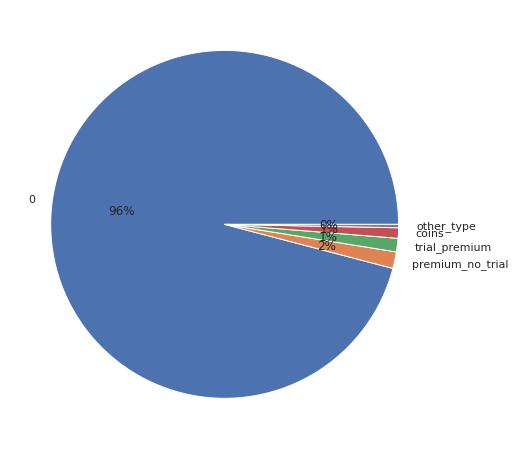

In [208]:
sns.set(
    style="whitegrid",
    rc={'figure.figsize':(20,8)})
plt.pie(df_product_type.count_uid, labels=df_product_type.product_type, autopct='%.0f%%')
plt.show()

По получившимся данным можно сказать, что в основном пользователи используют приложение бесплатно (96% - 12305), на втором месте идут пользователи, которые покупают премиум подписку без пробной (premium_no_trial) (1,5% - 198), затем идут пользователи которые приобретают пробную премиум подписку(trial_premium) (1.3% - 161), затем идут пользователи, которые покупают за внутреннюю валюту(1% - 124) и другие (0.3% - 40).

Посмотрим на пользователей, у которых был когда-либо премиум (либо пробный период премиум-статуса, либо купленный за деньги) и у кого никогда не было. Разобьем их на две категории и посчитаем кол-во пользователей (0 - никогда не было премиум, 1 - был хоть раз премиум(любой)).

In [209]:
df = group_all.groupby('was_premium', as_index=False) \
              .agg({'uid':'count'}) \
              .sort_values('uid') \
              .rename(columns = {'uid': 'count_uid'})
df

,was_premium,count_uid
1,1.0,1249
0,0.0,11579


Интересно, что пользователей, у которых was_premium = 0, меньше, чем пользователей, которые используют приложение бесплатно (product_type == 0). Рассмотрим, кто эти пользователи и почему так происходит. Сгруппируем таблицу по 'was_premium', 'is_premium', чтобы посмотреть в совокупности, по каждому product_type.

In [210]:
group_all.query('product_type == 0').groupby(['was_premium', 'is_premium'], as_index=False) \
              .agg({'uid':'count'}) \
              .sort_values('uid')
#кол-во пользователей сошлось по product_type == 0

,was_premium,is_premium,uid
2,1.0,1.0,111
1,1.0,0.0,646
0,0.0,0.0,11548


В итоге мы видим три категории пользователей с product_type == 0 (то есть тех кто не покупал ни один из типов продуктов):
1. был премиум и остался премиум, но при этом они ничего не покупали
2. был премиум, но сейчас не премиум, возможно это был пробный период
3. не было премиум и сейчас тоже нет

При этом всем, все эти пользователи ничего не покупали, это странно

In [211]:
group_all.query('product_type == "premium_no_trial"').groupby(['was_premium', 'is_premium'], as_index=False) \
              .agg({'uid':'count'}) \
              .sort_values('uid')

,was_premium,is_premium,uid
0,1.0,0.0,24
1,1.0,1.0,174


В итоге мы видим две категории пользователей с product_type == "premium_no_trial" (то есть тех кто покупал сразу премиум без пробной):
1. был премиум и остался премиум
2. был премиум, но сейчас не премиум, значит эти пользователи отменили премиум подписку

In [212]:
group_all.query('product_type == "trial_premium"').groupby(['was_premium', 'is_premium'], as_index=False) \
              .agg({'uid':'count'}) \
              .sort_values('uid')

,was_premium,is_premium,uid
0,1.0,0.0,2
1,1.0,1.0,159


В итоге мы видим две категории пользователей с product_type == "trial_premium" (то есть тех кто покупал пробную премиум подписку):
1. был премиум и остался премиум
2. был премиум, но сейчас не премиум, значит эти пользователи отменили даже пробную премиум подписку

Посмотрим отдельно на пользователей product_type == 0, более детально. Хочу разобраться почему у них был премиум, но при этом они его не покупали.

In [213]:
group_all.query('product_type == 0').groupby('joined_date', as_index=False).agg({'uid':'count'})

,joined_date,uid
0,1970-01-01,12305


In [214]:
group_all.query('product_type == 0').groupby(['was_premium', 'is_premium'], as_index=False) \
              .agg({'revenue':'sum'})

,was_premium,is_premium,revenue
0,0.0,0.0,0.0
1,1.0,0.0,0.0
2,1.0,1.0,0.0


In [215]:
group_all.query('product_type == 0').groupby(['was_premium', 'is_premium'], as_index=False) \
              .agg({'total_revenue':'sum'})

,was_premium,is_premium,total_revenue
0,0.0,0.0,0
1,1.0,0.0,0
2,1.0,1.0,0


Исходя из полученных данных, можем сказать, что либо у нас неправильно выгружаются данные по пользователям с product_type == 0, либо ранее (более точно сказать не могу, так как у пользователей нет даты регистрации) премиум подписки были бесплатны и потом стали платные, так как суммы по всем трем категориям по revenue = 0 и total_revenue = 0.

В связи с чем пользователей с product_type == 0, учитывать в нашем анализе мы не будем.

Оставим только пользователей с product_type == "trial_premium" и product_type == "premium_no_trial"

In [216]:
df_premium_all = group_all.query('product_type == "trial_premium" or product_type == "premium_no_trial"')

In [217]:
df_premium_all.head()

,uid,age,attraction_coeff,coins,country,visit_days,gender,was_premium,is_premium,total_revenue,grp,joined_at,paid_at,revenue,from_page,product_type,payment,joined_date,paid_date
20,891152790,29,769,0.0,Spain,"2,5,6",male,1.0,1.0,12597,1,2017-08-11 18:39:00,2017-10-11 11:29:00,12597.0,dating,premium_no_trial,1.0,2017-08-11,2017-10-11
111,892430988,28,181,0.0,United States of America,"1,2",male,1.0,1.0,12727,1,2017-10-14 07:02:00,2017-10-23 13:58:00,12727.0,trial_vip_popup,trial_premium,1.0,2017-10-14,2017-10-23
140,891919368,29,250,0.0,France,0,male,1.0,1.0,16536,1,2017-10-24 21:21:00,2017-10-31 23:21:00,16536.0,trial_vip_popup,trial_premium,1.0,2017-10-24,2017-10-31
154,891806436,32,57,0.0,Italy,"1,2,3,4,5,6,7,8,9,10,12,13,14,15,16,17,18,19",male,1.0,1.0,12597,1,2017-10-27 08:51:00,2017-10-30 17:34:00,12597.0,promo_09,premium_no_trial,1.0,2017-10-27,2017-10-30
194,891786216,21,250,0.0,Spain,0,male,1.0,1.0,12818,1,2017-10-27 18:20:00,2017-03-11 20:20:00,12818.0,trial_vip_popup,trial_premium,1.0,2017-10-27,2017-03-11


В итоге у нас остается **4 категории** пользователей:
1. **paid_premium** - была приобретена сразу премиум-подписка без пробной и сейчас есть (product_type == "premium_no_trial", 'was_premium' == 1 , 'is_premium' == 1)
2. **paid_premium_cancel** - была приобретена сразу премиум-подписка без пробной и сейчас ее нет, пользователи отменили (product_type == "premium_no_trial", 'was_premium' == 1 , 'is_premium' == 0)
3. **trial_premium** - была приобретена пробная премиум-подписка и сейчас есть (product_type == "trial_premium", 'was_premium' == 1 , 'is_premium' == 1)
4. **trial_premium_cancel** - была приобретена пробная премиум-подписка и сейчас ее нет, пользователи отменили ее (product_type == "trial_premium", 'was_premium' == 1 , 'is_premium' == 0)

Создадим новый столбец type_uid по 4 категориям:

In [218]:
df_premium_all.loc[(df_premium_all['was_premium'] == 1) & (df_premium_all['is_premium'] == 1) & (df_premium_all['product_type'] == 'premium_no_trial'), 'type_uid'] = 'paid_premium'
df_premium_all.loc[(df_premium_all['was_premium'] == 1) & (df_premium_all['is_premium'] == 0) & (df_premium_all['product_type'] == 'premium_no_trial'), 'type_uid'] = 'paid_premium_cancel'
df_premium_all.loc[(df_premium_all['was_premium'] == 1) & (df_premium_all['is_premium'] == 1) & (df_premium_all['product_type'] == 'trial_premium'), 'type_uid'] = 'trial_premium'
df_premium_all.loc[(df_premium_all['was_premium'] == 1) & (df_premium_all['is_premium'] == 0) & (df_premium_all['product_type'] == 'trial_premium'), 'type_uid'] = 'trial_premium_cancel'

/opt/tljh/user/lib/python3.7/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/tljh/user/lib/python3.7/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/tljh/user/lib/python3.7/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://panda

Делаю проверку на кол-во, все сходится

In [219]:
df_users_type = df_premium_all.groupby('type_uid', as_index=False) \
              .agg({'uid':'count'}) \
              .sort_values('uid', ascending=False) \
              .rename(columns = {'uid': 'count_uid'})
df_users_type

,type_uid,count_uid
0,paid_premium,174
2,trial_premium,159
1,paid_premium_cancel,24
3,trial_premium_cancel,2


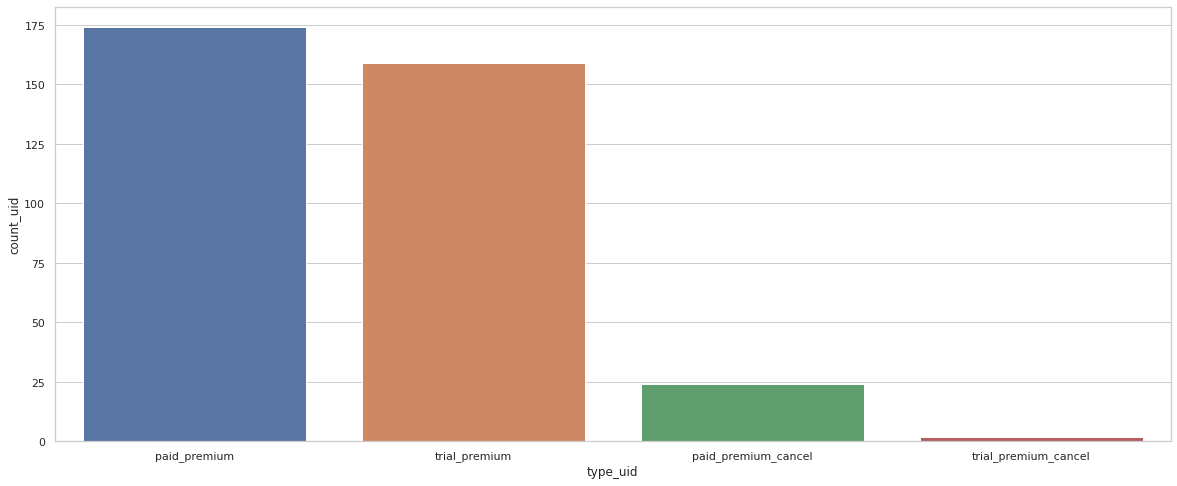

In [220]:
sns.set(
    style="whitegrid",
    rc={'figure.figsize':(20,8)})
sns.barplot(x='type_uid', y='count_uid', data=df_users_type)

И рассмотрим в пропорциональном отношении данные категории пользователей

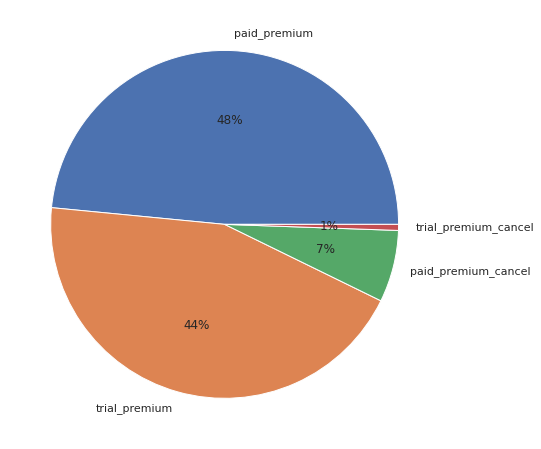

In [221]:
sns.set(
    style="whitegrid",
    rc={'figure.figsize':(20,8)})
plt.pie(df_users_type.count_uid, labels=df_users_type.type_uid, autopct='%.0f%%')
plt.show()

Видим, что большинство пользователей категории paid_premium - 48%, затем trial_premium - %. Потом идут paid_premium_cancel - 7% и потом всего 1% - trial_premium_cancel.

Рассмотрим наши категории со стороны возраста и пола, может ли это как-то влиять на платежеспособность пользователей.

In [222]:
df_age = df_premium_all.groupby('age', as_index=False) \
              .agg({'uid':'count'}) \
              .sort_values('age', ascending=False) \
              .rename(columns = {'uid': 'count_uid'})
df_age.head()

,age,count_uid
41,99,2
40,58,3
39,55,3
38,54,1
37,53,2


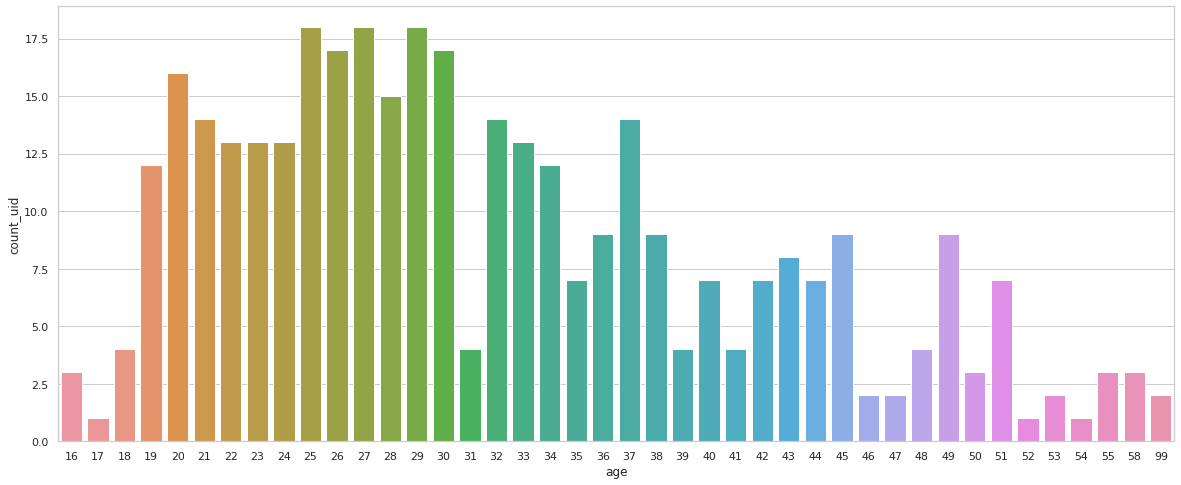

In [223]:
sns.set(
    style="whitegrid",
    rc={'figure.figsize':(20,8)})
sns.barplot(x='age', y='count_uid', data=df_age)

Посмотрев на график могу сказать, что скорее всего возраст в приложении никак не подтвержается документально (паспорт) и  пользователи, либо не заполняют его, либо вносят не достоверную информацию, так как присутсвуют пользователи с возрастом выше 70 лет (сомневаюсь, что люди в этом возрасте используют приложение). Так же есть пользователи от 16-17 лет, обычно в правилах дейтинг приложения возраст должен быть от 18 и старше. Можем сделать вывод, что на возраст ориентироваться не стоит.

In [224]:
df_gender = df_premium_all.groupby('gender', as_index=False) \
              .agg({'uid':'count'}) \
              .sort_values('uid', ascending=False) \
              .rename(columns = {'uid': 'count_uid'})
df_gender

,gender,count_uid
1,male,347
0,female,12


Уже сейчас видно, что пользователей мужчин преобладающее кол-во. Но мы все равно покажем это в процентном соотношении на круговой диаграмме.

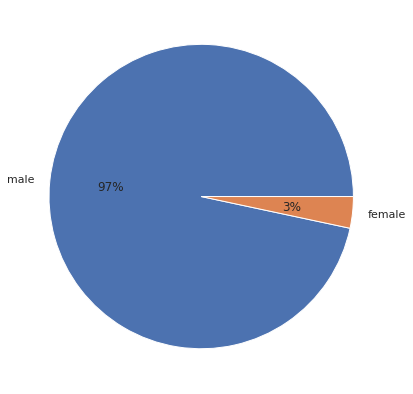

In [225]:
sns.set(
    style="whitegrid",
    rc={'figure.figsize':(20,7)})
plt.pie(df_gender.count_uid, labels=df_gender.gender, autopct='%.0f%%')
plt.show()

Теперь я хочу посмотреть по каждому гендеру отдельно по категориям type_uid, чтобы сопоставить именно в процентах между собой

In [226]:
df_gender_male = df_premium_all.query('gender == "male"').groupby('type_uid', as_index=False) \
              .agg({'uid':'count'}) \
              .sort_values('uid', ascending=False) \
              .rename(columns = {'uid': 'count_uid'})
df_gender_male  #gender == "male"

,type_uid,count_uid
0,paid_premium,170
2,trial_premium,152
1,paid_premium_cancel,23
3,trial_premium_cancel,2


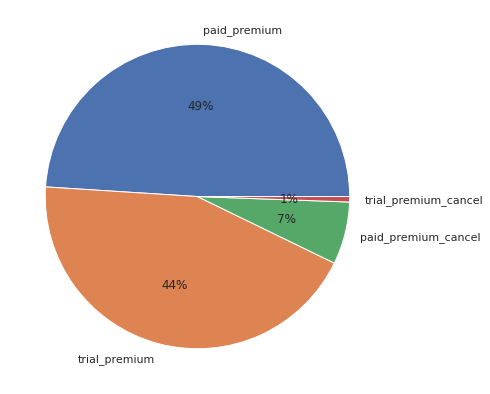

In [227]:
sns.set(
    style="whitegrid",
    rc={'figure.figsize':(20,7)})
plt.pie(df_gender_male.count_uid, labels=df_gender_male.type_uid, autopct='%.0f%%')
plt.show()

In [228]:
df_gender_female = df_premium_all.query('gender == "female"').groupby('type_uid', as_index=False) \
              .agg({'uid':'count'}) \
              .sort_values('uid', ascending=False) \
              .rename(columns = {'uid': 'count_uid'})
df_gender_female  #gender == "female"

,type_uid,count_uid
2,trial_premium,7
0,paid_premium,4
1,paid_premium_cancel,1


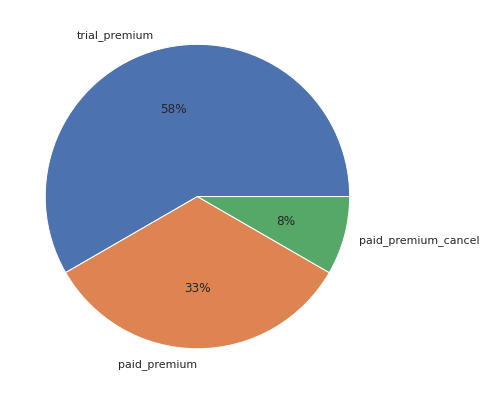

In [229]:
sns.set(
    style="whitegrid",
    rc={'figure.figsize':(20,7)})
plt.pie(df_gender_female.count_uid, labels=df_gender_female.type_uid, autopct='%.0f%%')
plt.show()

Сравнивая два категории gender, можем сделать **вывод**, что пользователи gender == "male" в преобладающем кол-ве. И что пользователи gender == "male" берут премиум-подписку больше, чем gender == "female", независимо от их кол-ва.

Так же рассмотрим влияет ли коэффициент привлекательности "attraction_coeff" на покупку подписки.

In [230]:
df_coeff = df_premium_all.groupby(['attraction_coeff', 'type_uid'], as_index=False) \
              .agg({'uid': 'count'}) \
              .rename(columns = {'uid': 'count_uid'})
df_coeff_2 = df_coeff.pivot_table(index = 'attraction_coeff', columns='type_uid', values='count_uid', fill_value=0) \
         .reset_index()
df_coeff_2

type_uid,attraction_coeff,paid_premium,paid_premium_cancel,trial_premium,trial_premium_cancel
0,0,11,4,28,0
1,16,0,0,1,0
2,37,1,0,0,0
3,41,0,0,2,0
4,43,1,0,1,0
...,...,...,...,...,...
202,875,0,0,1,0
203,903,1,0,0,0
204,933,0,0,1,0
205,935,1,0,0,0


Рассмотрим в отдельности по каждой из 4 категорий, для наглядности изобразим сразу на графиках

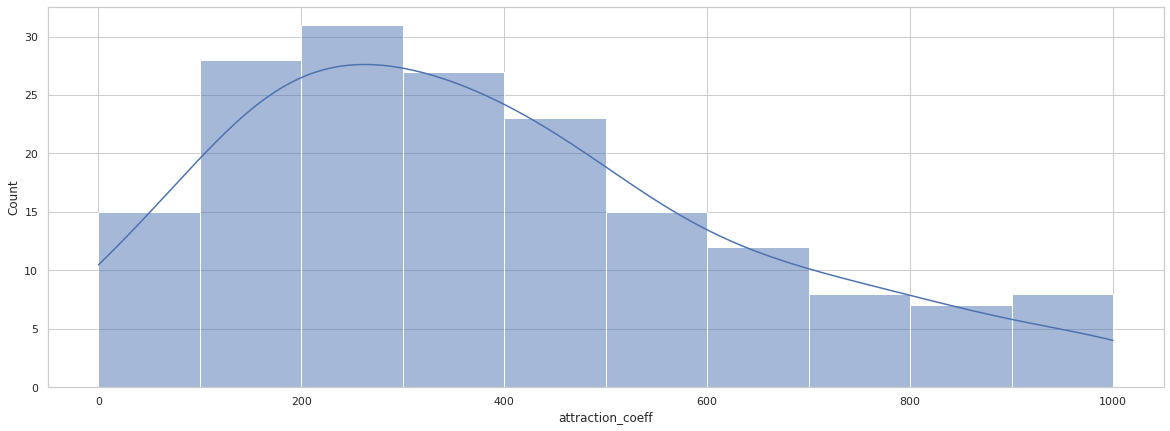

In [231]:
sns.set(
    style="whitegrid",
    rc={'figure.figsize':(20,7)})
sns.histplot(data=df_premium_all.query('type_uid == "paid_premium"'), x="attraction_coeff", kde=True, bins=10)
plt.show() #paid_premium - была приобретена сразу премиум-подписка без пробной и сейчас есть

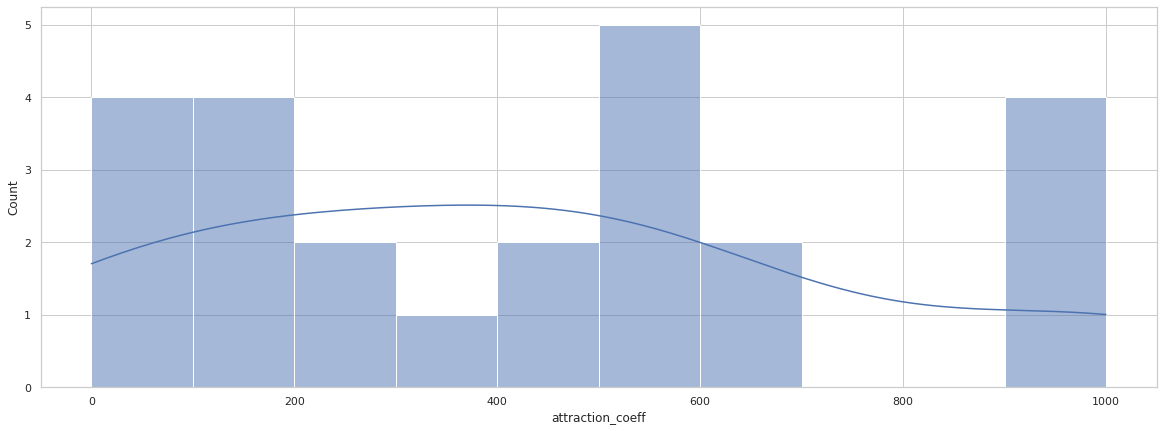

In [232]:
sns.set(
    style="whitegrid",
    rc={'figure.figsize':(20,7)})
sns.histplot(data=df_premium_all.query('type_uid == "paid_premium_cancel"'), x="attraction_coeff", kde=True, bins=10)
plt.show() #paid_premium_cancel - была приобретена сразу премиум-подписка без пробной и сейчас ее нет, пользователи отменили

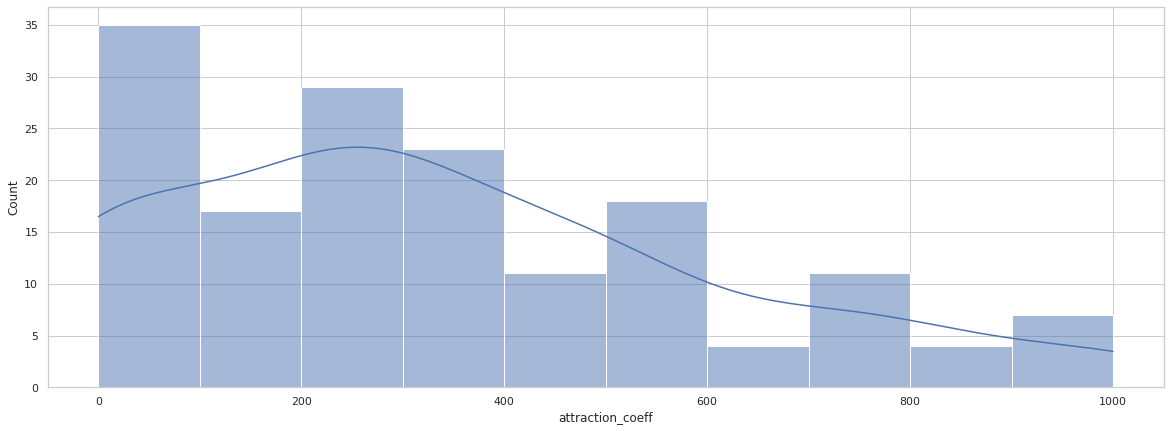

In [233]:
sns.set(
    style="whitegrid",
    rc={'figure.figsize':(20,7)})
sns.histplot(data=df_premium_all.query('type_uid == "trial_premium"'), x="attraction_coeff", kde=True, bins=10)
plt.show() #trial_premium - была приобретена пробная премиум-подписка и сейчас есть

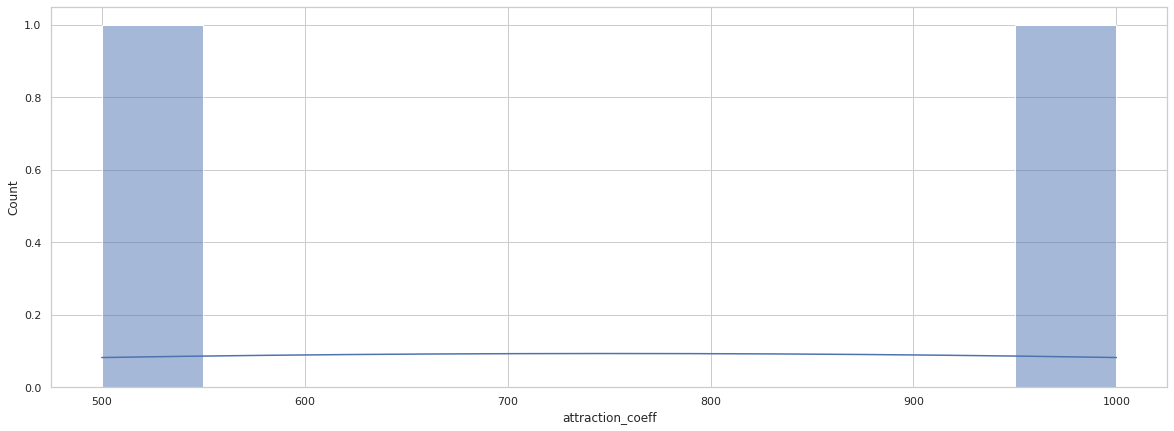

In [234]:
sns.set(
    style="whitegrid",
    rc={'figure.figsize':(20,7)})
sns.histplot(data=df_premium_all.query('type_uid == "trial_premium_cancel"'), x="attraction_coeff", kde=True, bins=10)
plt.show() #trial_premium_cancel - была приобретена пробная премиум-подписка и сейчас ее нет, пользователи отменили ее

Смотря по нашим графики, можно сказать, что конверсия просмотра в лайк увеличивается если вы покупаете премиум подписку. Это можно увидеть на графике, где у пользователей пробная подписка (график 3)

Рассмотрим, как долго и часто пользуются приложением после регистрации visit_days и влияет ли на это премиум подписка. Для этого создадим новый столбец count_days, в котором будет общее кол-во дней посещения после регистрации.

In [235]:
def count_days(x):
    return x.split(',')

df_premium_all['count_days_numbers'] = df_premium_all['visit_days'].apply(count_days)

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [236]:
def count_days_2(x):
    if '0' in x:
        return 0
    else:
        return sum(1 for elem in x if elem.isdigit())

df_premium_all['count_days'] = df_premium_all['count_days_numbers'].apply(count_days_2)

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [237]:
df_premium_all = df_premium_all.drop(columns='count_days_numbers')

Изобразим на графиках

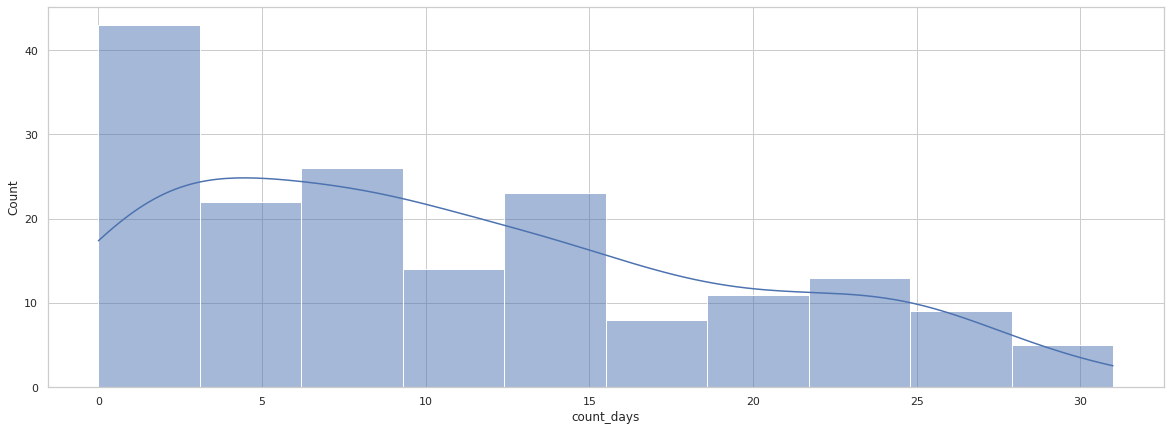

In [238]:
sns.set(
    style="whitegrid",
    rc={'figure.figsize':(20,7)})
sns.histplot(data=df_premium_all.query('type_uid == "paid_premium"'), x="count_days", kde=True, bins=10)
plt.show() #paid_premium - была приобретена сразу премиум-подписка без пробной и сейчас есть

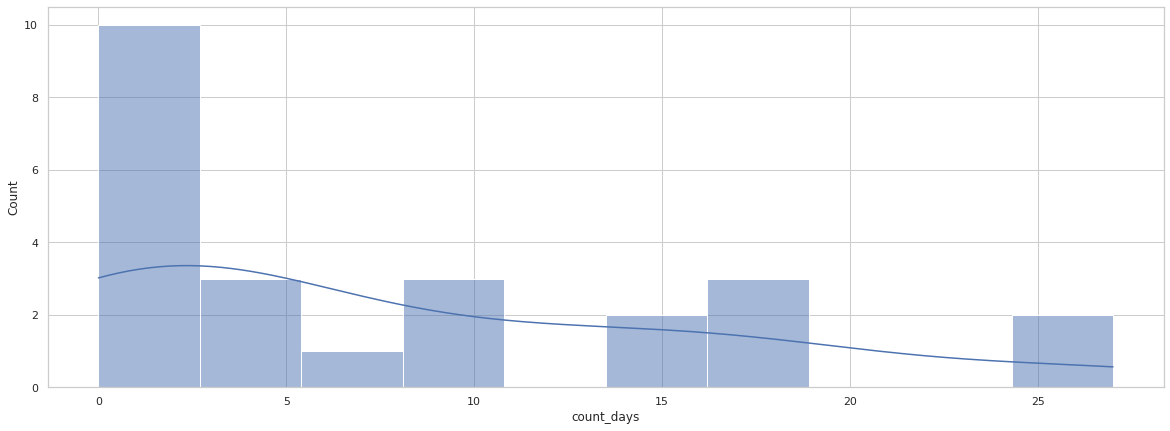

In [239]:
sns.set(
    style="whitegrid",
    rc={'figure.figsize':(20,7)})
sns.histplot(data=df_premium_all.query('type_uid == "paid_premium_cancel"'), x="count_days", kde=True, bins=10)
plt.show() #paid_premium_cancel - была приобретена сразу премиум-подписка без пробной и сейчас ее нет, пользователи отменили

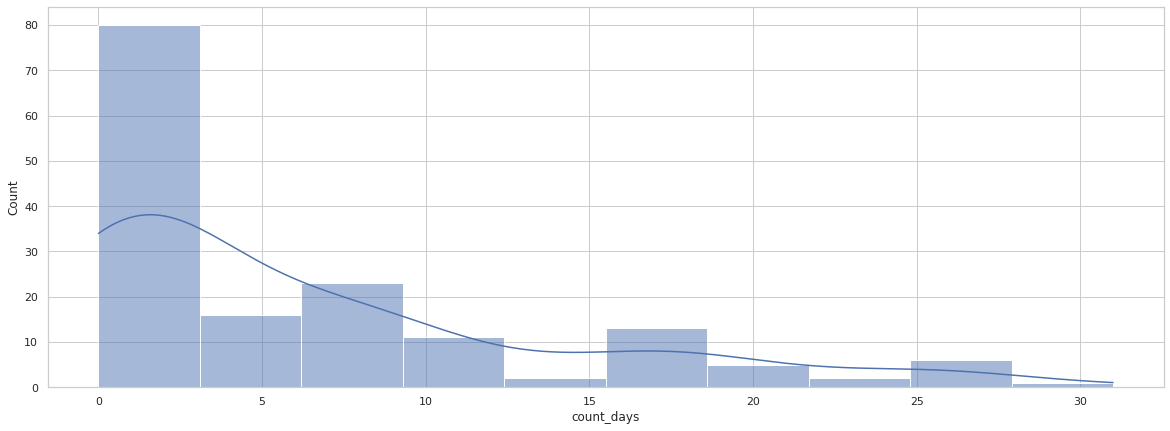

In [240]:
sns.set(
    style="whitegrid",
    rc={'figure.figsize':(20,7)})
sns.histplot(data=df_premium_all.query('type_uid == "trial_premium"'), x="count_days", kde=True, bins=10)
plt.show() #trial_premium - была приобретена пробная премиум-подписка и сейчас есть

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:306: UserWarning:

Dataset has 0 variance; skipping density estimate.



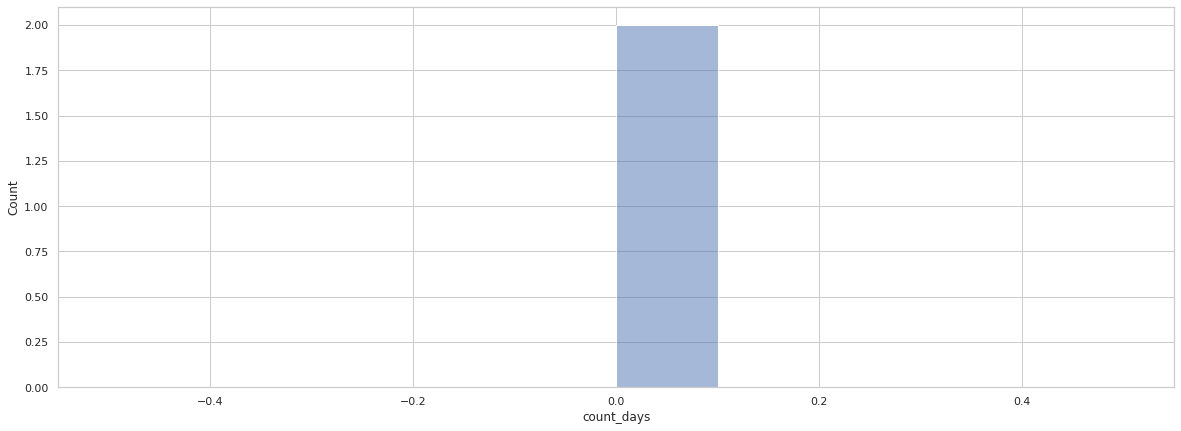

In [241]:
sns.set(
    style="whitegrid",
    rc={'figure.figsize':(20,7)})
sns.histplot(data=df_premium_all.query('type_uid == "trial_premium_cancel"'), x="count_days", kde=True, bins=10)
plt.show() #trial_premium_cancel - была приобретена пробная премиум-подписка и сейчас ее нет, пользователи отменили ее

На графиках мы явно видим, что присутсвует влияние платной услуги на кол-во дней посещения пользователями

Рассмотрим по отдельности, пользователей которые заходили и которые не заходили совсем, к какой категории они относятся больше всего

In [242]:
df_count_day_0 = df_premium_all.query('count_days == 0').groupby('type_uid', as_index =False).agg({'uid':'count'})

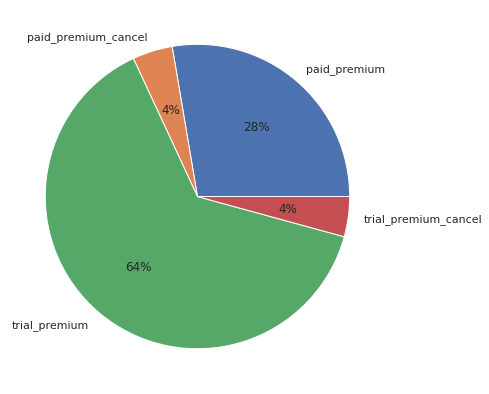

In [243]:
sns.set(
    style="whitegrid",
    rc={'figure.figsize':(20,7)})
plt.pie(df_count_day_0.uid, labels=df_count_day_0.type_uid, autopct='%.0f%%')
plt.show()

In [244]:
df_count_day_1 = df_premium_all.query('count_days > 0').groupby('type_uid', as_index =False).agg({'uid':'count'})

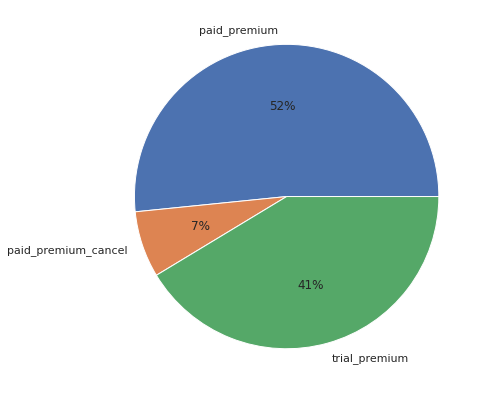

In [245]:
sns.set(
    style="whitegrid",
    rc={'figure.figsize':(20,7)})
plt.pie(df_count_day_1.uid, labels=df_count_day_1.type_uid, autopct='%.0f%%')
plt.show()

Мы видим, что % пользователей с платной подпиской (paid_premium) заметно увеличился на 24%, это еще раз подтверждает, что пользователи оплатившие платные услуги чаще заходят в приложение. Могу предположить, что платная подписка выступает своего рода мотивацией для пользователей заходить в приложение чаще.

Так же рассмотрим откуда к нам переходят большинство пользователей для оплаты (from_page). Рассмотрим источники и суммы поступающие по ним.

In [246]:
df_from_page = df_premium_all.query('from_page != 0') \
         .groupby('from_page', as_index = False) \
         .agg({'uid':'count'}) \
         .rename(columns = {'uid': 'count_uid'}) \
         .sort_values('count_uid', ascending=False)

df_from_page.head()

,from_page,count_uid
10,trial_vip_popup,138
0,autoreply_message,59
8,promo_09,39
5,none,38
4,left_sidebar_menu,32


In [247]:
df_from_page_2 = df_premium_all.query('from_page != 0') \
                          .groupby('from_page', as_index = False) \
                          .agg({'total_revenue':'sum'}) \
                          .rename(columns = {'total_revenue': 'sum_total_revenue'}) \
                          .sort_values('sum_total_revenue', ascending=False)

df_from_page_2.head()

,from_page,sum_total_revenue
10,trial_vip_popup,1727934
0,autoreply_message,562146
8,promo_09,513682
4,left_sidebar_menu,376792
5,none,256269


In [248]:
merged_df = df_from_page.merge(df_from_page_2, on='from_page').sort_values('sum_total_revenue', ascending=False)

merged_df.head()

,from_page,count_uid,sum_total_revenue
0,trial_vip_popup,138,1727934
1,autoreply_message,59,562146
2,promo_09,39,513682
4,left_sidebar_menu,32,376792
3,none,38,256269


Можем сейчас сказать, что больше всего пользователей пользующихся платной услугой совершают покупку переходя из "trial_vip_popup" и "autoreply_message". Так же больше всего денег приносят нам переходы из этих же каналов.

Теперь посмотрим распределение пользователей по группам (grp), насколько оно вообще нормальное и равномерное.

In [249]:
df_premium_all.head()

,uid,age,attraction_coeff,coins,country,visit_days,gender,was_premium,is_premium,total_revenue,...,joined_at,paid_at,revenue,from_page,product_type,payment,joined_date,paid_date,type_uid,count_days
20,891152790,29,769,0.0,Spain,"2,5,6",male,1.0,1.0,12597,...,2017-08-11 18:39:00,2017-10-11 11:29:00,12597.0,dating,premium_no_trial,1.0,2017-08-11,2017-10-11,paid_premium,3
111,892430988,28,181,0.0,United States of America,"1,2",male,1.0,1.0,12727,...,2017-10-14 07:02:00,2017-10-23 13:58:00,12727.0,trial_vip_popup,trial_premium,1.0,2017-10-14,2017-10-23,trial_premium,2
140,891919368,29,250,0.0,France,0,male,1.0,1.0,16536,...,2017-10-24 21:21:00,2017-10-31 23:21:00,16536.0,trial_vip_popup,trial_premium,1.0,2017-10-24,2017-10-31,trial_premium,0
154,891806436,32,57,0.0,Italy,"1,2,3,4,5,6,7,8,9,10,12,13,14,15,16,17,18,19",male,1.0,1.0,12597,...,2017-10-27 08:51:00,2017-10-30 17:34:00,12597.0,promo_09,premium_no_trial,1.0,2017-10-27,2017-10-30,paid_premium,18
194,891786216,21,250,0.0,Spain,0,male,1.0,1.0,12818,...,2017-10-27 18:20:00,2017-03-11 20:20:00,12818.0,trial_vip_popup,trial_premium,1.0,2017-10-27,2017-03-11,trial_premium,0


In [250]:
df_premium_all.groupby('grp', as_index=False).agg({'uid':'count'}).rename(columns = {'uid': 'count_uid'})

,grp,count_uid
0,1,103
1,2,133
2,3,123


Можем сказать, что пользователи поделены на группы достаточно равномерно

Посмотрим распредление по гендеру

In [251]:
df_gender_grp = df_premium_all.groupby(['gender', 'grp'], as_index=False) \
              .agg({'uid': 'count'}) \
              .rename(columns = {'uid': 'count_uid'})
df_gender_grp_2 = df_gender_grp.pivot_table(index = 'gender', columns='grp', values='count_uid', fill_value=0) \
         .reset_index()

df_gender_grp_2.head()

grp,gender,1,2,3
0,female,2,4,6
1,male,101,129,117


Распределение именно в рамках каждого гендера достаточно равномерно, но вместе их рассматривать не желательно

Рассмотрим распределение по каждой стране и изобразим на графике, для наглядности. Но здесь мы рассмотрим в двух проекцих: - всех пользователей и - только пользователи type_uid == "paid_premium" и type_uid == "trial_premium"

In [252]:
df_country_grp = df_premium_all.groupby(['country', 'grp'], as_index=False) \
                               .agg({'uid': 'count'}) \
                               .rename(columns = {'uid': 'count_uid'}) \
                               .sort_values('count_uid', ascending=False)
df_country_grp.head()

,country,grp,count_uid
46,United States of America,3,46
45,United States of America,2,41
44,United States of America,1,35
16,France,2,15
31,Spain,1,12


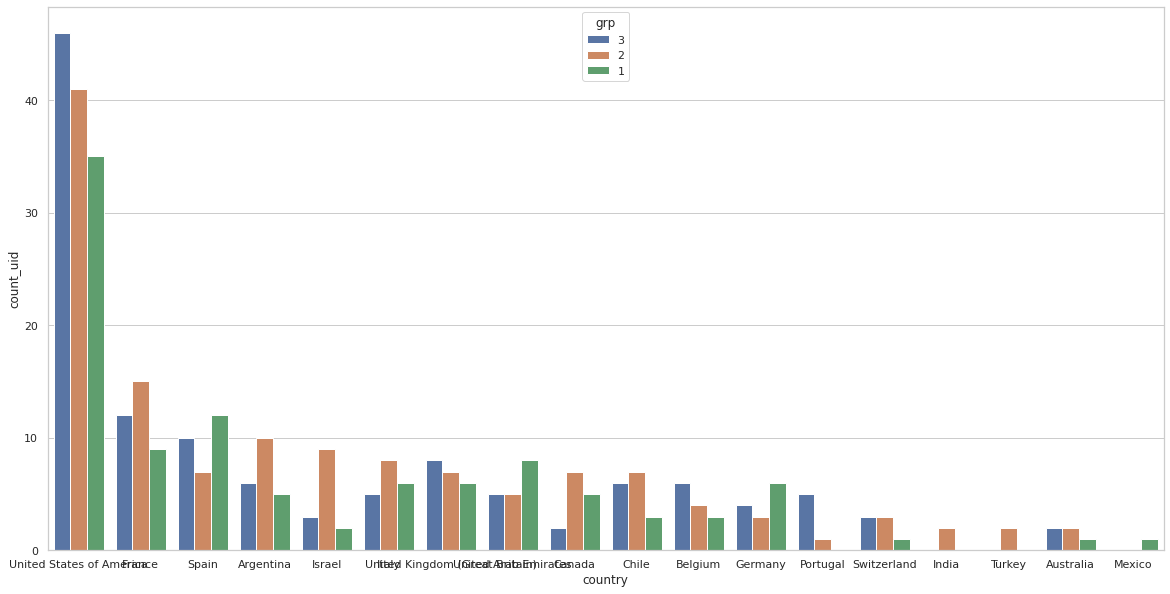

In [253]:
sns.set(
    style="whitegrid",
    rc={'figure.figsize':(20,10)})

sns.barplot(data=df_country_grp, x="country", y='count_uid', hue="grp") 

#вижу, что график не особо читаем, поэтому попробуем сократить кол-во стран, возьмем только те страны, у кого пользователей больше 6

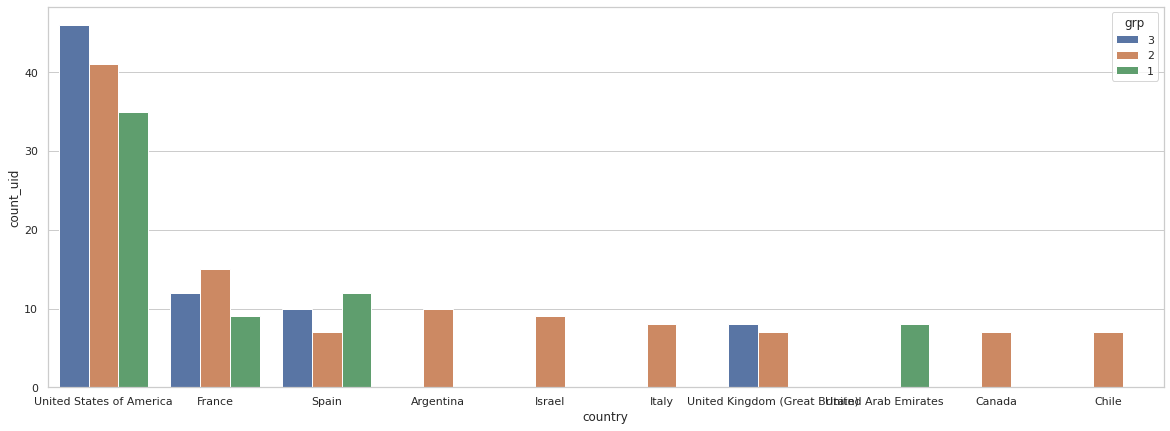

In [254]:
sns.set(
    style="whitegrid",
    rc={'figure.figsize':(20,7)})

sns.barplot(data=df_country_grp.query('count_uid > 6'), x="country", y='count_uid', hue="grp")

In [255]:
df_country_grp_2 = df_premium_all.query('type_uid == "trial_premium" or type_uid == "paid_premium"') \
                                 .groupby(['country', 'grp'], as_index=False) \
                                 .agg({'uid': 'count'}) \
                                 .rename(columns = {'uid': 'count_uid'}) \
                                 .sort_values('count_uid', ascending=False)

df_country_grp_2.head()

,country,grp,count_uid
46,United States of America,3,42
45,United States of America,2,37
44,United States of America,1,32
31,Spain,1,12
16,France,2,11


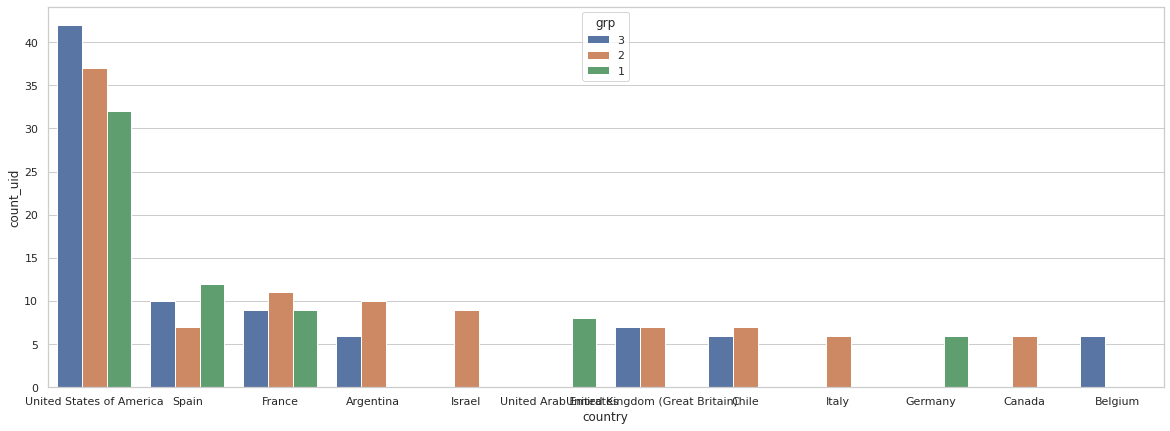

In [256]:
sns.set(
    style="whitegrid",
    rc={'figure.figsize':(20,7)})

sns.barplot(data=df_country_grp_2.query('count_uid > 5'), x="country", y='count_uid', hue="grp")

Согласно графикам можно сказать, что распределения в категориях не особо равномерны, например есть страны, где пользоватлей нет в двух группах из трех, например Мексика. Если в дальнейшем на это ориентироваться, то надо оставлять только те страны, где есть хотя бы 1 пользователь в каждой из трех групп.

Теперь можем перейти к **A/B тестированию**.

Определим **метрики**, которые будем проверять исходя из задания (сфокусируемся на данных в разрезе пробные/премиум):
- **ARPPU (Average revenue per paying user)** - средний доход с платного пользователя пробной премиум-подписки, type_uid == "trial_premium"
- **ARPPU (Average revenue per paying user)** - средний доход с платного пользователя постоянной премиум-подписки, type_uid == "paid_premium"
- **CR** - конверсия из пользователя пробной премиум-подписки в пользователя с постоянной премиум-подпиской


Пользователи поделены на **три группы:** тестовая (grp == 1), первая контрольная (grp == 2) и вторая контрольная (grp == 3). Объединю пользователей в двух контрольных группах в одну, чтобы можно было посмотреть на разницу между тестом и контролем.

**Первая метрика**

Для того, чтобы проверить **первую метрику ARPPU**, так как она количественная (или та, которую можно измерить) выбираем **тт-тест  или сравниваем средние**.

Сформулируем нулевую гипотезу и альтернативную:
- (H0): средние доходы в группах равны
- (H1): не равны

Проверим выполнение условий на нормальность и поверим соблюдения гомогенности (равенство дисперсий).

Беру столбец revenue так как мы хотим посмотреть, как влияет премиум на средний доход, а именно в этом столбце мы можем посмотреть оплату подписки, в total_revenue будут все возможные списания

In [298]:
dff_trial_premium = df_premium_all.query('type_uid == "trial_premium"')

In [299]:
#берём данные группы 1

df_trial_group_test = dff_trial_premium.query('grp == "1"').revenue

scipy.stats.normaltest(df_trial_group_test)

NormaltestResult(statistic=0.7623488337060574, pvalue=0.6830587422732881)

In [300]:
#берём данные группы 2 и 3

df_trial_group_control = dff_trial_premium.query('grp == "2" or grp == "3"').revenue

scipy.stats.normaltest(df_trial_group_control)

NormaltestResult(statistic=3.875964866391156, pvalue=0.14399417477214746)

Тесты показали, что значения в группах распределены нормально, так как pvalue > 0.05

Проверим равенство дисперсий, используем F-тест для проверки равенства двух дисперсий совокупности. 

Нулевая и альтернативная гипотезы для теста следующие:

- H0 : σ1 = σ2 (дисперсии равны)
- H1 : σ1 ≠ σ2 (дисперсии не равны)

In [301]:
def f_test(x, y):
    x = np.array(x)
    y = np.array(y)
    f = np.var(x, ddof=1)/np.var(y, ddof=1) #calculate F test statistic 
    dfn = x.size-1 #define degrees of freedom numerator 
    dfd = y.size-1 #define degrees of freedom denominator 
    p = 1-scipy.stats.f.cdf(f, dfn, dfd) #find p-value of F test statistic 
    return f, p

In [302]:
x = df_trial_group_test
y = df_trial_group_control

In [303]:
#perform F-test
f_test(x, y)

(0.9353546744674116, 0.5975704199765048)

p-value > 0.05 - дисперсии равны, можем отклонить нулевую гипотезу

Тест на нормальность выполнен успешно, тест на равенство дисперсий тоже прошел успешно. Можем использовать тт-тест.

In [304]:
scipy.stats.ttest_ind(df_trial_group_test, df_trial_group_control)

#сравниваем средние в 1 и 2/3 группах

Ttest_indResult(statistic=2.0985384869215475, pvalue=0.0374582890523804)

Тест показал, что pvalue < 0.05, поэтому мы отклоняем нулевую гипотезу и делаем вывод, 
что средние в группах значимо различаются

In [305]:
dff_trial_premium.groupby('grp', as_index=False).agg({'revenue':'mean'}).round(2)

,grp,revenue
0,1,12684.50
1,2,11573.51
2,3,12175.98


In [306]:
(11573.51 + 12175.98) / 2

#средний revenue у 2 и 3 групп

11874.744999999999

Посмотрим на сколько процентов изменился средний доход в первой (тест) группе по сравнению со второй/третьей (контроль)

In [307]:
((11874.75 - 12684.50) / 12684.50) * 100

-6.383775474003706

Средний доход снизился на 6.4%

**Вторая метрика**

Для того, чтобы проверить **вторую метрику ARPPU**, выбираем так же **тт-тест  или сравниваем средние**.

Сформулируем нулевую гипотезу и альтернативную:
- (H0): средние доходы в группах равны
- (H1): не равны

Проверим выполнение условий на нормальность и поверим соблюдения гомогенности.

Беру столбец revenue так как мы хотим посмотреть, как влияет премиум на средний доход, а именно в этом столбце мы можем посмотреть оплату подписки, в total_revenue будут все возможные списания

In [308]:
dff_paid_premium = df_premium_all.query('type_uid == "paid_premium"')

In [309]:
#берём данные группы 1

df_paid_group_test = dff_paid_premium.query('grp == "1"').revenue

scipy.stats.normaltest(df_paid_group_test)

NormaltestResult(statistic=98.90377698165513, pvalue=3.336704205653839e-22)

In [310]:
#берём данные группы 2 и 3

df_paid_group_control = dff_paid_premium.query('grp == "2" or grp == "3"').revenue

scipy.stats.normaltest(df_paid_group_control)

NormaltestResult(statistic=180.1792752782876, pvalue=7.491477796103147e-40)

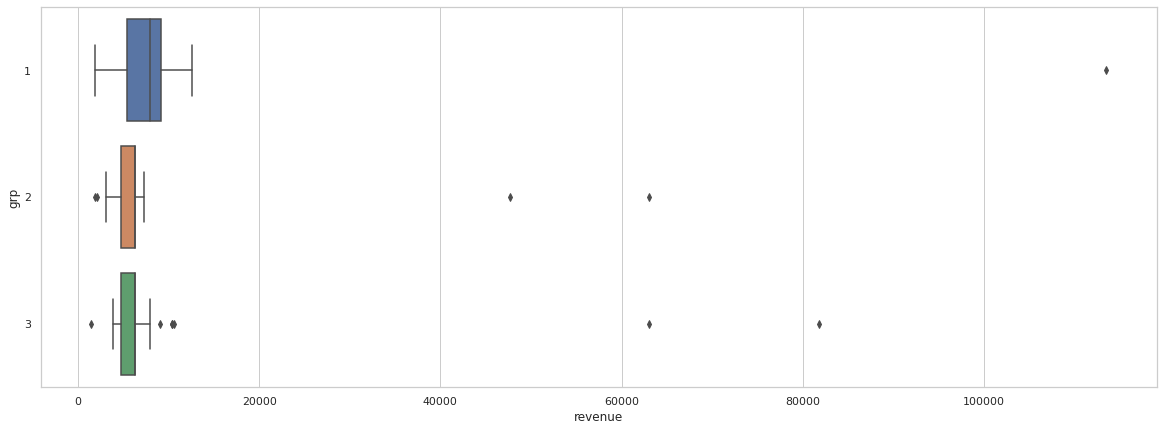

In [311]:
sns.boxplot(data=dff_paid_premium, x="revenue", y="grp")

Проверим равенство дисперсий, используем F-тест для проверки равенства двух дисперсий совокупности. 

Нулевая и альтернативная гипотезы для теста следующие:

- H0 : σ1 = σ2 (дисперсии равны)
- H1 : σ1 ≠ σ2 (дисперсии не равны)

In [312]:
def f_test(x, y):
    x = np.array(x)
    y = np.array(y)
    f = np.var(x, ddof=1)/np.var(y, ddof=1) #calculate F test statistic 
    dfn = x.size-1 #define degrees of freedom numerator 
    dfd = y.size-1 #define degrees of freedom denominator 
    p = 1-scipy.stats.f.cdf(f, dfn, dfd) #find p-value of F test statistic 
    return f, p

In [313]:
x = df_paid_group_test
y = df_paid_group_control

In [314]:
#perform F-test
f_test(x, y)

(2.356831407326043, 0.00010538084900812983)

p-value < 0.05 - дисперсии не равны (несоблюдение гомогенности)

Тест на нормальность провален, тест на соблюдения гомогенности тоже.
Мы не можем использовать тт-тест, возьмем в качестве теста метод bootstrap.

Сформулируем нулевую гипотезу и альтернативную:
- (H0): разница средних равна нулю
- (H1): не равна нулю

In [315]:
dff_paid_premium_2_3 = dff_paid_premium.query('grp == "2" or grp == "3"')

In [316]:
dff_paid_premium_test_1 = dff_paid_premium[dff_paid_premium.grp == '1']
dff_paid_premium_control_23 = dff_paid_premium[(dff_paid_premium['grp'] == '2') | (dff_paid_premium['grp'] == '3')]

In [317]:
bootstrap((dff_paid_premium_test_1.revenue, ), np.mean)

BootstrapResult(confidence_interval=ConfidenceInterval(low=7446.977777777778, high=21227.645719310272), standard_error=2368.1094032337032)

In [318]:
bootstrap((dff_paid_premium_control_23.revenue, ), np.mean)

BootstrapResult(confidence_interval=ConfidenceInterval(low=6190.671648418632, high=10064.955362411978), standard_error=907.0203696043802)

Исходя из полученных доверительных интервалов, можем сказать, что доверительный интервал не накрывает 0, можем отвергнуть нулевую гипотезу.

Посмотрим на средний доход в группах

In [319]:
dff_paid_premium.groupby('grp', as_index=False).agg({'revenue':'mean'}).round(2)

,grp,revenue
0,1,10081.07
1,2,7194.95
2,3,7792.39


In [320]:
(7194.95 + 7792.39) / 2

#средний revenue у 2 и 3 групп

7493.67

Посмотрим на сколько процентов изменился средний доход в первой (тест) группе по сравнению со второй/третьей (контроль)

In [321]:
((7493.67 - 10081.07) / 10081.07) * 100

-25.665926335200528

Средний доход снизился на 25.7%

**Третья метрика**

**CR** - конверсия из пользователя пробной премиум-подписки в пользователя с постоянной премиум-подпиской. Так как это конверсия, то используем **хи-квадрат**.

Сформулируем нулевую гипотезу и альтернативную:
- (H0): переменные не связаны друг с другом
- (H1): связь есть

Выделим из нашей таблицы маленькую таблицу, где будут видны только пользователи по группам (grp) и будет признак (type_uid)

In [322]:
df_type_uid_grp = df_premium_all.query('type_uid == "paid_premium" or type_uid == "trial_premium"') \
              .groupby(['type_uid', 'grp'], as_index=False) \
              .agg({'uid': 'count'}) \
              .rename(columns = {'uid': 'count_uid'})
df_type_uid_grp_2 = df_type_uid_grp.pivot_table(index = 'type_uid', columns='grp', values='count_uid', fill_value=0).reset_index()

df_type_uid_grp_2

grp,type_uid,1,2,3
0,paid_premium,45,59,70
1,trial_premium,52,63,44


Посчитаем конверсию для пользователей в первой группе (тест)

In [323]:
45 / (52+45) * 100

46.391752577319586

Конверсия пользователя с пробной подпиской в пользователя с премиум подпиской для тестовой группы (1) равна 46.4

Посчитаем конверсию для второй и третьей групп (контроль)

In [324]:
(59+70) / (63+59+70+40) * 100

55.603448275862064

Конверсия пользователя с пробной подпиской в пользователя с премиум подпиской для контрольных групп (2 и 3) равна 55.6

Исходя из полученных данных, мы можем сказать, что при изменении цены премиум подписки конверсия пользователя из пользователя пробной подписки в пользователя платной премиум подписки изменилась статистически существенно.

Используем хи-квадрат

In [325]:
a =[45, 52] 

#1 группа

In [326]:
b =[129, 107]

#2 и 3 группы

Используем хи-квадрат

In [327]:
ss.chi2_contingency([a, b])

(1.5672825168642859,
 0.2106020974005553,
 1,
 array([[ 50.68468468,  46.31531532],
        [123.31531532, 112.68468468]]))

p_value равен 0.2106 (р_value > 0.05), что означает, что мы не можем отвергнуть нулевую гипотезу. Это означает, что нет статистически значимой связи между типом подписки (пробная или постоянная) и конверсией пользователей. Таким образом, на основании данного теста мы не можем утверждать, что существует связь между типом подписки и конверсией пользователей.

**ВЫВОДЫ**

Результаты проведения A/B тестирования:
- изменение стоимости премиум-подписки влияет на средний доход с платного пользователя пробной премиум-подписки,средний доход снизился на 6.4%
- изменение стоимости премиум-подписки влияет на средний доход с платного пользователя постоянной премиум-подписки, средний доход снизился на 25.7%

Исходя из полученных результатов можно сделать вывод, что изменение стоимости премиум-подписки отрицательно сказывается на среднем доходе с платного пользователя, как для пробной премиум-подписки, так и для постоянной премиум-подписки. Средний доход уменьшился на 6.4% и 25.7%.
Нет статистически значимой связи между типом подписки (пробная или постоянная) и конверсией пользователей. Это означает, что тип подписки не влияет на вероятность конверсии пользователей.
В целом, изменение стоимости премиум-подписки снизило доход с платных пользователей обеих типов подписок, но не повлияло на конверсию. Важно учитывать эти факторы при принятии дальнейших решений по ценообразованию. Считаю, что эксперимент не был успешен.